In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import wandb
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [6]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml']

In [7]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [8]:
mushroom_config = {
#     'sections': config,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 256,
        'num_clusters': (8, 4, 2,),
        'dtype_to_decoder_dims': {'multiplex': (256, 128, 64,), 'visium': (256, 512, 1024 * 2,), 'xenium': (256, 256, 256,)},
        'recon_scaler': 1.,
        'neigh_scaler': 1.,
        'codebook_dim': 64,
    },
    'trainer_kwargs': {
        'input_ppm': 0.4705882352941177,
        'target_ppm': .01, # 100 microns per tile
        'contrast_pct': None,
        'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 8,
        'devices': 1,
        'accelerator': 'gpu',
        'enable_checkpointing': True,
        'max_epochs': 50,
        'steps_per_epoch': 200,
        'channel_mapping': channel_mapping,
        'lr': 1e-4,
        'save_every': 1,
        'save_dir': './',
        'log_dir': './',
        'log_every_n_steps': 10,
#         'logger_project': 'model_testing_S18-9906',
        'logger_channel': 'CD45',
        'logger_type': 'wandb'
    },
}

In [9]:
config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/integrated_{case}_v1/outputs')
save_dir = os.path.join(out_dir, 'chkpts')
log_dir = os.path.join(out_dir, 'logs')

Path(save_dir).mkdir(parents=True, exist_ok=True)

config = yaml.safe_load(open(config_fp))

In [10]:
config

[{'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s0_xenium.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s2_xenium.h5ad'}],
  'id': 's2',
  'position': 35},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s3_multiplex.ome.tiff'}],
  'id': 's3',
  'position': 40},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s4_xenium.h5ad'}],
  'id': 's4',
  'position': 75},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s5_multiple

In [11]:
mushroom_config['sections'] = config
mushroom_config['trainer_kwargs']['logger_project'] = f'model_testing_integrated_{case}'
mushroom_config['trainer_kwargs']['save_dir'] = save_dir
mushroom_config['trainer_kwargs']['log_dir'] = log_dir

In [12]:
yaml.safe_dump(
    mushroom_config,
    open(os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml'), 'w')
)

In [13]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's3', 's5', 's7']
INFO:root:processing sections
INFO:root:generating image data for section s1
INFO:root:generating image data for section s3
INFO:root:generating image data for section s5
INFO:root:generating image data for section s7
INFO:root:starting xenium processing
INFO:root:using 377 channels
INFO:root:4 sections detected: ['s0', 's2', 's4', 's6']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s2
INFO:root:generating image data for section s4
INFO:root:generating image data for section s6
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 8 sections detected: [('s0', 'xenium'), ('s1', 'multiplex'), ('s2', 'xenium'), ('s3', 'multiplex'), ('s4', 'xenium'), ('s5', 'multiplex'), ('s6', 'xenium'), ('s7', 'multiplex')]
INFO:root:creating data loaders
INFO:root:cr

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
%%time
batch = next(iter(mushroom.train_dl))

CPU times: user 10.6 ms, sys: 492 ms, total: 503 ms
Wall time: 2.72 s


In [15]:
batch.keys()

dict_keys(['tiles', 'slides', 'dtypes', 'pairs', 'is_anchor'])

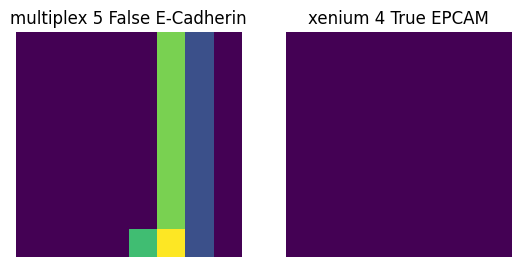

In [16]:
idx = 0
mushroom.train_dl.dataset.display_batch(
    batch, idx, mushroom.learner_data.dtype_to_channels,
    display_channels={'xenium': 'EPCAM', 'multiplex': 'E-Cadherin'}
)

In [17]:
device = mushroom.model.device
with torch.no_grad():
    tiles, slides, dtypes = batch['tiles'], batch['slides'], batch['dtypes']
    pairs, is_anchor = batch['pairs'], batch['is_anchor']
    
    tiles, slides, dtypes = [x.to(device) for x in tiles], [x.to(device) for x in slides], [x.to(device) for x in dtypes]
    pairs, is_anchor = [x.to(device) for x in pairs], [x.to(device) for x in is_anchor]
    losses, outputs = mushroom.model.sae(tiles, slides, dtypes, pairs=pairs, is_anchor=is_anchor)

In [18]:
losses

{'neigh_loss_level_0': tensor(1.9500),
 'recon_loss_0_multiplex': tensor(0.9775),
 'recon_loss_0_xenium': tensor(0.6131),
 'neigh_loss_level_1': tensor(1.2556),
 'recon_loss_1_multiplex': tensor(0.9776),
 'recon_loss_1_xenium': tensor(0.6131),
 'neigh_loss_level_2': tensor(0.5563),
 'recon_loss_2_multiplex': tensor(0.9775),
 'recon_loss_2_xenium': tensor(0.6131),
 'recon_loss': tensor(4.7719),
 'neigh_loss': tensor(3.7618),
 'overall_loss': tensor(4.7719)}

In [19]:
outputs.keys()

dict_keys(['encoded_tokens_prequant', 'level_to_encoded', 'cluster_probs', 'clusters', 'dtype_to_true_pixels', 'dtype_to_pred_pixels'])

In [20]:
for level in outputs['cluster_probs']: print(level.shape)

torch.Size([128, 64, 8])
torch.Size([128, 64, 4])
torch.Size([128, 64, 2])


In [21]:
for level in outputs['clusters']: print(level.shape)

torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])


In [22]:
for level in outputs['clusters']: print(level.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([0, 1, 2, 3])
tensor([0, 1])


In [23]:
for level in outputs['level_to_encoded']: print(len(level.sum(-1).unique()))

8
32
64


In [24]:
outputs['dtype_to_true_pixels']['multiplex'].shape

torch.Size([64, 64, 24])

In [25]:
outputs['dtype_to_true_pixels']['xenium'].shape

torch.Size([64, 64, 377])

In [26]:
outputs['dtype_to_pred_pixels']['multiplex'].shape

torch.Size([3, 64, 64, 24])

In [27]:
outputs['dtype_to_pred_pixels']['xenium'].shape

torch.Size([3, 64, 64, 377])

In [28]:
# ~11 iter per second

In [29]:
mushroom.train()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/testing/mushroom/integrated_S18-9906_v1/outputs/chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 10.3 M
------------------------------
10.3 M    Trainable params
0         Non-trainable params
10.3 M    Total params
41.146    Total estimated model params size (MB)


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=50` reached.


In [30]:
mushroom.embed_sections()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

In [141]:
# outputs = []
# pl_module = mushroom.model
# with torch.no_grad():
#     for batch in mushroom.inference_dl:
#         tiles, slides, dtypes = batch['tiles'], batch['slides'], batch['dtypes']
#         tiles = [x.to(pl_module.device) for x in tiles]
#         slides = [x.to(pl_module.device) for x in slides]
#         dtypes = [x.to(pl_module.device) for x in dtypes]
#         outs = pl_module.forward(tiles, slides, dtypes)
#         outputs.append(outs)

In [146]:
# out = mushroom.model.format_prediction_outputs(outputs)

In [30]:
os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml')

'/data/estorrs/mushroom/data/projects/testing/mushroom/integrated_S18-9906_v1/outputs/chkpts/mushroom_config.yaml'

In [31]:
new = Mushroom.from_config(
    os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml'),
    chkpt_filepath='/data/estorrs/mushroom/data/projects/testing/mushroom/integrated_S18-9906_v1/outputs/chkpts/epoch=24-step=5000.ckpt',
    accelerator='cpu'
)


INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's3', 's5', 's7']
INFO:root:processing sections
INFO:root:generating image data for section s1
INFO:root:generating image data for section s3
INFO:root:generating image data for section s5
INFO:root:generating image data for section s7
INFO:root:starting xenium processing
INFO:root:using 377 channels
INFO:root:4 sections detected: ['s0', 's2', 's4', 's6']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s2
INFO:root:generating image data for section s4
INFO:root:generating image data for section s6
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 8 sections detected: [('s0', 'xenium'), ('s1', 'multiplex'), ('s2', 'xenium'), ('s3', 'multiplex'), ('s4', 'xenium'), ('s5', 'multiplex'), ('s6', 'xenium'), ('s7', 'multiplex')]
INFO:root:creating data loaders
INFO:root:cr

In [32]:
new.embed_sections()

Predicting: |                                                                                       | 0/? [00:…

In [33]:
dtype_to_df = new.get_cluster_intensities()
dtype_to_df['multiplex']

,AMACR,AR,CD20,CD31,CD3e,CD4,CD45,CD68,CD8,CK14,...,FOXP3,HLA-DR,Ki67,LYVE1,Pan-Cytokeratin,Podoplanin,SMA,STEAP4,Vimentin,p63
0,-0.075879,-0.063842,-0.140464,-0.086570,-0.096992,-0.280484,-0.200345,0.941478,-0.057095,-0.132161,...,-0.085210,-0.112946,-0.007369,-0.041564,0.430066,-0.082364,-0.562744,-0.038264,-0.412725,-0.120767
1,-0.054293,-0.388655,-0.306254,-0.562370,-0.513792,-0.547095,-0.659351,-0.673730,-0.129784,-0.145967,...,-0.024927,-0.369506,-0.124683,-0.599095,-0.638352,-0.158536,-0.787826,-0.093658,-0.708080,-0.078822
3,-0.040286,0.252900,0.120100,0.205502,0.022112,-0.027075,0.228072,0.312634,-0.091335,-0.060451,...,-0.010171,-0.000362,0.025229,0.273119,0.488834,-0.026094,0.332635,-0.040131,0.314255,-0.067180
4,-0.057207,-0.138344,-0.069076,0.055752,-0.036859,-0.051710,0.230864,-0.396024,-0.094071,-0.074325,...,-0.048118,-0.163546,-0.084581,0.091742,-0.418855,-0.051220,0.947917,-0.061513,0.232722,-0.087149
6,0.720414,0.997875,1.085300,1.742278,2.056628,2.086501,1.831290,0.892772,0.832875,0.424755,...,0.516655,1.328357,0.930629,0.973448,0.246027,0.679508,-0.171729,0.647469,1.416379,0.698053
7,0.846208,2.133924,1.570336,4.169398,5.103756,5.602214,4.485672,1.957796,1.383739,0.834660,...,1.630265,3.828772,1.410628,2.278286,-0.701298,0.878224,-0.125918,1.858817,3.377431,0.914130
8,-0.084106,0.337464,0.427911,1.735103,2.784621,3.266443,1.584640,1.345721,0.454360,-0.118869,...,0.102347,3.207620,0.172346,0.657007,-0.439405,0.255851,-0.297581,0.261647,2.591625,-0.001256
9,-0.293770,-0.117240,0.544636,2.127390,3.832672,4.909232,1.755462,2.282974,0.545001,-0.116712,...,-0.157856,5.823325,0.053960,0.715935,-0.325883,0.259273,-0.634519,-0.031525,3.520750,-0.116850
10,0.753086,0.892180,0.998980,0.892581,0.984899,0.976084,0.997454,1.001091,0.720160,0.371095,...,0.669582,0.697690,0.754788,0.939495,0.799684,0.753335,-0.011324,0.548793,0.841397,0.659875
11,2.785859,0.917258,3.272837,1.732036,1.687019,1.307649,1.904757,0.713771,3.709212,1.712619,...,0.716712,0.372163,3.104803,0.946392,0.259910,3.536572,0.039921,0.552465,0.602767,3.695713


In [34]:
dtype_to_df['xenium']

,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,ADH1C,...,TRAC,TREM2,TSPAN19,UBE2C,UMOD,UPK3B,VCAN,VSIG4,VWA5A,VWF
0,0.085226,0.078425,-0.142658,-0.519705,-0.473089,-0.150889,-0.276940,-0.005239,-0.159469,-0.071372,...,-0.211685,-0.085993,0.196171,0.054236,0.070239,-0.021414,-0.213490,-0.171373,-0.212920,-0.143956
1,-0.233987,-0.252466,-0.200837,-0.792105,-0.844518,-0.361154,-0.577306,-0.237431,-0.335254,-0.410666,...,-0.324878,-0.210264,-0.379903,-0.320547,-0.126566,-0.112074,-0.456799,-0.258191,-0.473465,-0.315000
2,-0.202386,-0.087391,0.108048,-0.572103,0.164789,3.108516,-0.361902,1.165683,-0.131481,-0.265011,...,2.710585,4.481334,-0.040688,0.638070,0.038918,0.134527,0.886856,4.051434,1.001623,-0.164393
3,0.179972,0.165106,0.042094,0.344880,0.395565,0.067742,0.286602,0.098354,0.183382,0.253653,...,-0.062707,0.026745,0.262143,0.193178,0.092974,0.059322,0.204107,0.057183,0.192776,0.164335
4,-0.116623,-0.088171,-0.003770,0.654007,0.633605,-0.050158,0.299669,-0.060124,-0.009912,0.076100,...,0.010671,-0.052102,-0.186871,-0.124247,-0.073564,-0.032718,0.057017,0.050674,0.100656,-0.011804
5,-0.216343,-0.076504,0.222031,-0.313748,0.228548,2.368995,-0.145807,0.950382,0.031871,-0.196123,...,2.298214,3.256914,-0.107707,0.440519,0.001656,0.109047,0.844618,2.933070,0.821156,0.000342
6,0.249348,0.416662,0.538787,-0.066815,0.011687,1.087031,0.780487,0.542047,0.791879,0.394192,...,0.726072,0.573106,0.611318,0.580769,0.188588,0.436813,1.269935,0.475497,1.328083,0.669991
7,-0.013941,0.430321,2.419778,0.370991,0.912731,5.632119,1.008776,2.065400,2.215245,0.728727,...,7.418081,0.212812,1.014768,1.327839,0.124420,0.299689,1.782917,0.337279,1.853661,1.752403
8,-0.129839,0.058634,1.436920,0.875943,0.670862,0.966496,1.395467,0.321530,1.823373,0.285564,...,1.328933,0.385373,0.093069,0.142736,-0.005378,0.085919,1.380754,0.568663,1.085186,1.654840
9,0.278312,0.744260,0.219327,-0.041966,0.164311,2.036905,1.675818,0.634633,0.620298,0.602125,...,0.622945,0.859757,0.693397,0.867572,0.109133,1.163511,2.732736,0.734687,3.224196,0.331195


array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's5'}>,
        <Axes: title={'center': 's7'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

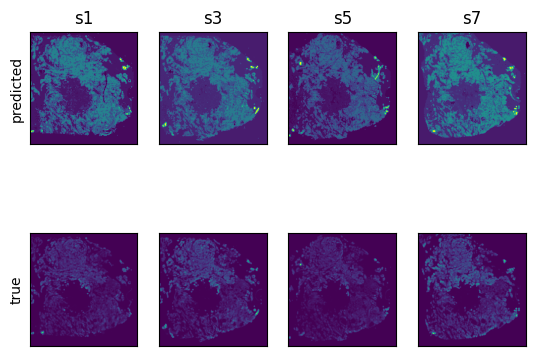

In [36]:
new.display_predicted_pixels('Pan-Cytokeratin', 'multiplex', level=-1)

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's6'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

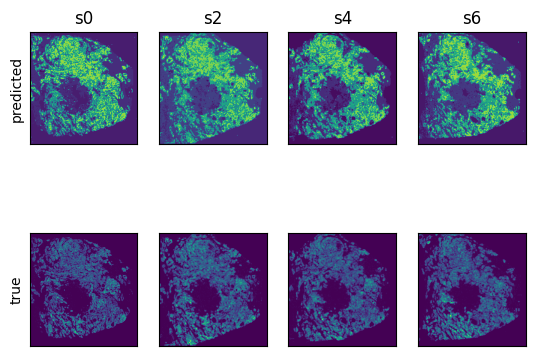

In [37]:
new.display_predicted_pixels('EPCAM', 'xenium', level=-1)

(8, 188, 180, 8)
(8, 188, 180, 8)


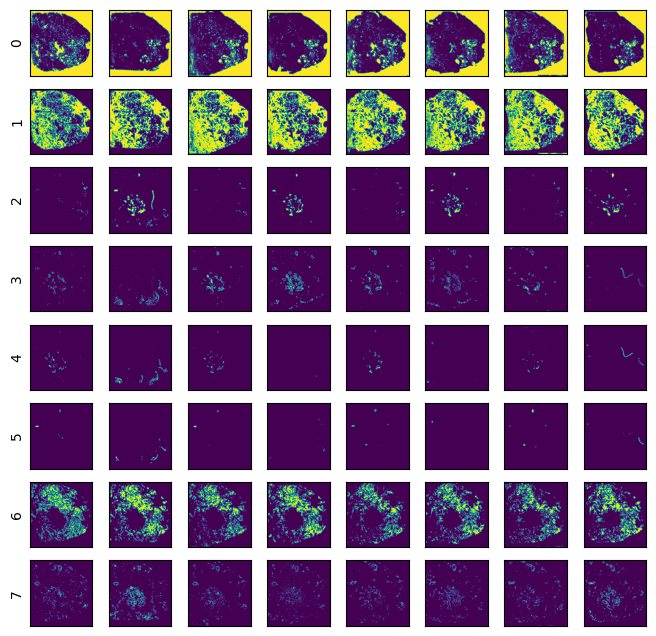

In [47]:
new.display_cluster_probs(level=0)

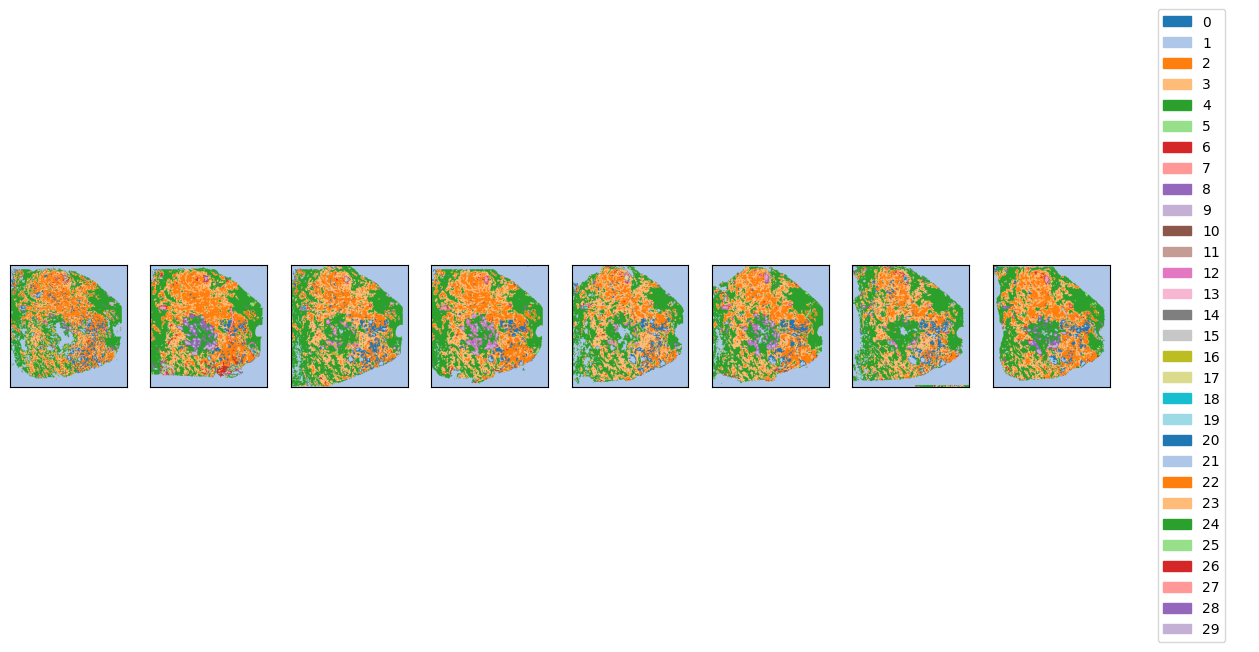

In [45]:
new.display_clusters()

In [55]:
volume = new.generate_interpolated_volume(z_scaler=.1)
volume.shape

(13, 188, 180)

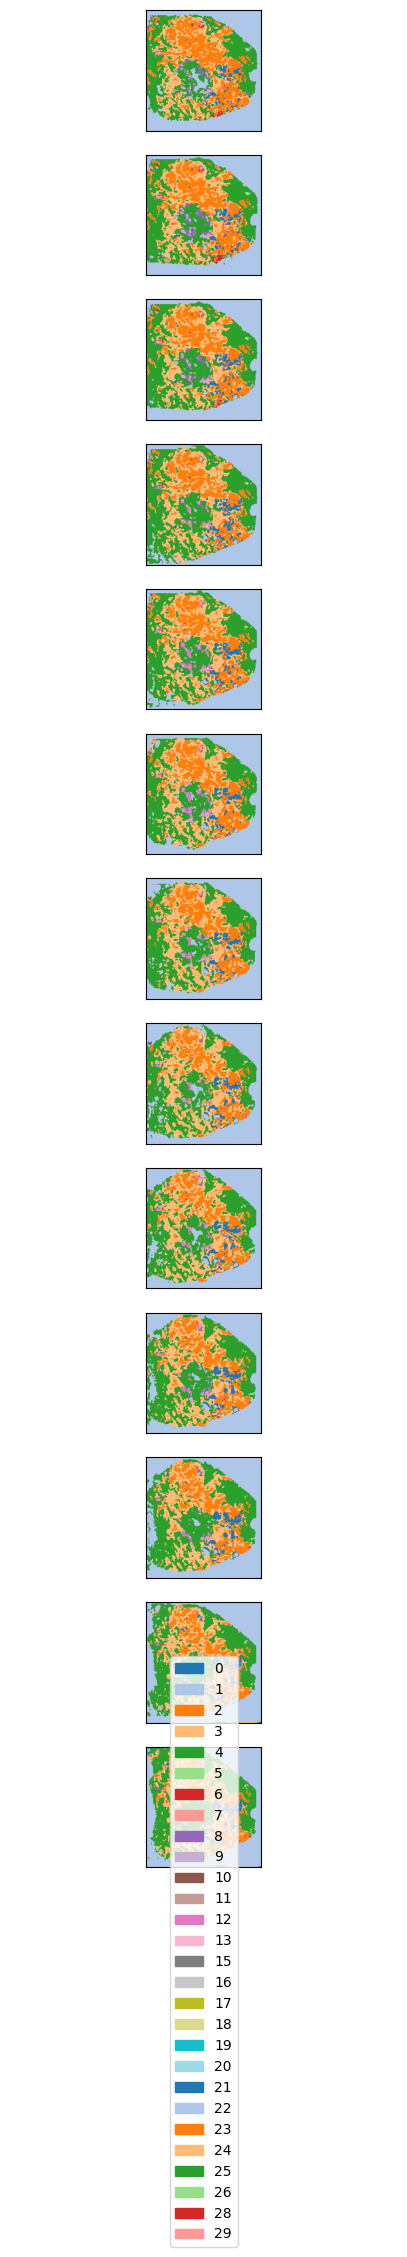

In [57]:
vis_utils.display_clusters(volume, horizontal=False, preserve_indices=True)